In [37]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold')
rcParams["figure.facecolor"] = 'white'
from scipy.optimize import curve_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
rcParams['figure.dpi'] = 150

In [39]:
import sys, numpy as np, scipy as sc, warnings, os#, healpy as H
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/modules/')
import foregrounds as fg, misc, flatsky, misc, exp_specs

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)
#warnings.filterwarnings('ignore', category=OptimizeWarning)

In [40]:
#params
expname = 's4wide'
#expname = 'cmbhd'
#expname = 's4deep'
#expname = 's4deepv3r025' #20201019
specs_dic, corr_noise_bands, rho, corr_noise = exp_specs.get_exp_specs(expname)
freqarr = sorted( specs_dic.keys() )
print(freqarr)
nc = len( freqarr )
TParr = ['T', 'P']

#for Neff: T/P available
param_dict = {}
nside, lmax = 2048, 5000
#which_sim_set = '202002_foregrounds_extragalactic_cmb_tophat'
which_sim_set = '202102_design_tool_input'
if (1): #S4-wide
    data_folder = '/Volumes/data_PHD_WD_babbloo/s4/cmbs4/map_based_simulations/%s/4096/' %(which_sim_set)
    param_dict['cl_gal_dic_dust_fname'] = '%s/dust/0000/s4like_mask_v2/cls_galactic_sims_dust_nside%s_lmax%s_cos_el_40.npy' %(data_folder, nside, lmax)
    param_dict['cl_gal_dic_sync_fname'] = '%s/synchrotron/0000/s4like_mask_v2/cls_galactic_sims_sync_nside%s_lmax%s_cos_el_40.npy' %(data_folder, nside, lmax)
    extra_str = 'pySM3/s4like_mask_v2/'
if (0): #S4-delensing
    data_folder = '/Volumes/data_PHD_WD_babbloo/s4/cmbs4/map_based_simulations/%s/4096/' %(which_sim_set)
    param_dict['cl_gal_dic_dust_fname'] = '%s/dust/0000/s4delensing_mask/cls_galactic_sims_dust_nside%s_lmax%s_delensing.npy' %(data_folder, nside, lmax)
    param_dict['cl_gal_dic_sync_fname'] = '%s/synchrotron/0000/s4delensing_mask/cls_galactic_sims_sync_nside%s_lmax%s_delensing.npy' %(data_folder, nside, lmax)
    extra_str = 'pySM3/s4delensing_mask/'
    
param_dict['lmax'] = lmax
param_dict['Dlfile_len'] = '/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/data/output_planck_r_0.0_2015_cosmo_lensedCls.dat'

[27, 39, 93, 145, 225, 278]


In [41]:
#beam and noise arr
beamarr = []
noisearr_T, elkneearr_T, alphakneearr_T = [], [], []
noisearr_P, elkneearr_P, alphakneearr_P = [], [], []
for freq in freqarr:
    beam_arcmins, white_noise_T, elknee_T, alphaknee_T, white_noise_P, elknee_P, alphaknee_P = specs_dic[freq]
    beamarr.append(beam_arcmins)
    noisearr_T.append(white_noise_T)
    noisearr_P.append(white_noise_P)
    elkneearr_T.append(elknee_T)
    elkneearr_P.append(elknee_P)
    alphakneearr_T.append(alphaknee_T)
    alphakneearr_P.append(alphaknee_P)    

print(elkneearr_T)

#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]
        
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax']+1)
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], label = freq)
    legend(loc = 1)

[415.0, 391.0, 1932.0, 3917.0, 6740.0, 6792.0]
dict_keys([27, 39, 93, 145, 225, 278])


In [42]:
#CAMB output for plotting
camb_file = param_dict['Dlfile_len']
Tcmb = 2.725
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

In [45]:
mask_str_dic = None
#alpha_dic = {93: 0.3, 145: 0.6, 225: 0.8, 278: 1.}
alpha_dic = {93: .5, 145: 1., 225: 1., 278: 1.}
lw_dic = {93: 1., 145: 1., 225: 1.5, 278: 2.}
ls_dic = {93: '-.', 145: '-', 225: '--', 278: ':'}

tot_mask_iter = 4
color_dic = {0:'navy', 1: 'green', 2: 'goldenrod', 3: 'darkred'}

tot_mask_iter = 5
color_dic = {0:'navy', 1: 'green', 2: 'goldenrod', 3: 'orangered', 4: 'darkred'}

tot_mask_iter = 4
color_dic = {0:'navy', 1: 'green', 2: 'goldenrod', 3: 'darkred'}
reqd_masks = []
if extra_str.find('s4like_mask_v2')>-1 or extra_str.find('s4delensing')>-1:
    tot_mask_iter = 6
    if extra_str.find('s4delensing')>-1:
        reqd_masks = [0]
    else:
        #reqd_masks = [0, 1, 2, 3, 4, 5]
        reqd_masks = [2]#, 5]
    #color_dic = {0:'navy', 1: 'darkblue', 2: 'royalblue', 3: 'orangered', 4: 'darkred', 5: 'maroon'}
    cmap = cm.jet
    color_dic = {0:cmap(0), 1: cmap(15), 2: cmap(30), 3: cmap(230), 4: cmap(240), 5: cmap(255)}
    if (1):
        freqarr = [27, 39, 93, 145, 225, 278]
        color_dic = {}
        tmpfcntr = 0
        for f1 in freqarr:
            for f2 in freqarr:
                if f1 != f2: continue
                color_dic[(f1, f2)] = cm.jet(tmpfcntr)
                tmpfcntr += 40
    #freqarr = [27, 93, 145, 225, 278]
    #freqarr = [225, 278]
    #freqarr = [93, 145]
    #freqarr = [27, 39]
    which_spec = 'TT' #EE'#'TT' #EE' #TT'


 (27, 27)

 (39, 39)

 (93, 93)

 (145, 145)

 (225, 225)

 (278, 278)


<Figure size 900x600 with 0 Axes>

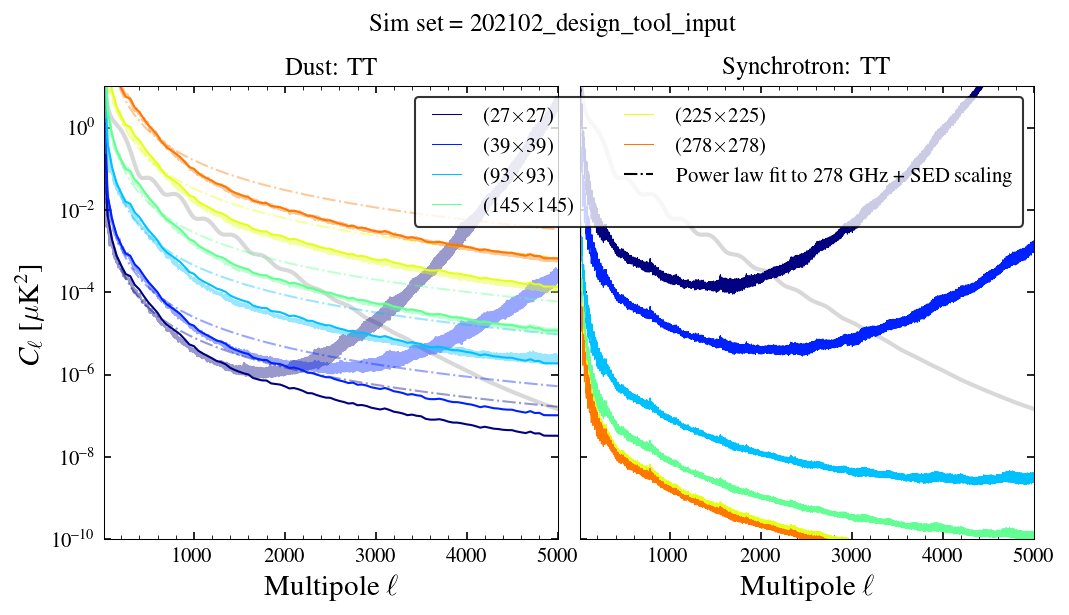

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [51]:
show_sync = 1
clf()
if show_sync:
    fig = figure(figsize=(8., 4.))
    subplots_adjust(wspace=0.05)
#xscale_val = 'log' ##None#'log' #None
xscale_val = None
tot_freq_iter = len(freqarr)
which_gal_mask = 2 
plot_done = []
xmin = 10
xmax = 5000#7100 #lmax+100
ymin, ymax = 1e-10, 10.
Tdust, beta_dust = 20., 1.54 #https://pysm3.readthedocs.io/en/latest/models.html#dust
#Tdust, beta_dust = 20., 1.3 #https://pysm3.readthedocs.io/en/latest/models.html#dust
for freq1 in freqarr:
    for freq2 in freqarr:

        if (freq1, freq2) in plot_done: continue

        if freq1 != freq2: continue

        el, cl_dust = fg.get_cl_galactic(param_dict, 'dust', freq1, freq2, which_spec = which_spec, which_gal_mask = which_gal_mask, bl_dic = bl_dic)
        el, cl_dust_actual = fg.get_cl_galactic(param_dict, 'dust', freq1, freq2, which_spec = which_spec, which_gal_mask = which_gal_mask, bl_dic = bl_dic, use_sed_scaling = False, use_power_law_fit = False)
        el, cl_dust_with_beam = fg.get_cl_galactic(param_dict, 'dust', freq1, freq2, which_spec = which_spec, which_gal_mask = which_gal_mask)

        el, cl_sync = fg.get_cl_galactic(param_dict, 'sync', freq1, freq2, which_spec = which_spec, which_gal_mask = which_gal_mask, bl_dic = bl_dic)
        el, cl_sync_actual = fg.get_cl_galactic(param_dict, 'sync', freq1, freq2, which_spec = which_spec, which_gal_mask = which_gal_mask, bl_dic = bl_dic, use_power_law_fit = False)

        if (1): #perform fitting
            ell_norm = 80
            def power_law(ell, A, alpha, ell_norm = 80.):
                #print(A, alpha)#, end = ' ')
                fit = A * ((ell / ell_norm) ** alpha)
                badinds = np.where((fit == np.inf) | (fit == np.nan))[0]
                fit[badinds]=0.
                return fit
            def perform_fit(el, cl, ell_norm = 80):
                dl_fac = (el * (el + 1))/2/np.pi
                dl = cl * dl_fac
                badinds = np.where((dl == np.inf) | (dl == np.nan))[0]
                dl[badinds]=0.
                amp_ini = dl[el == ell_norm][0]
                if which_spec == 'EE':
                    alpha_ini = -.4
                elif which_spec == 'TT':
                    alpha_ini = -.3
                #print(amp_ini*0.1, amp_ini*3., alpha_ini-0.2, alpha_ini+0.2); sys.exit()
                delta_alpha = 0.1
                amp_low_fac, amp_high_fac = 0.95, 1.05 #0.1, 3.
                pars, cov = curve_fit(f=power_law, xdata=el, ydata=dl, p0=[amp_ini, alpha_ini], bounds = ((amp_ini*amp_low_fac, alpha_ini-delta_alpha), (amp_ini*amp_high_fac, alpha_ini+delta_alpha)))
                
                dl_fit = power_law(el, pars[0], pars[1])
                cl_fit = dl_fit / dl_fac

                return cl_fit

            for dust_sync_iter in range(2):
                if dust_sync_iter == 0:
                    cl_dust_sync = np.copy(cl_dust)
                elif dust_sync_iter == 1:
                    cl_dust_sync = np.copy(cl_sync)
                if dust_sync_iter == 0: 
                    cl_dust_fit = perform_fit(el, cl_dust_sync, ell_norm = ell_norm)
                elif dust_sync_iter == 1: 
                    cl_sync_fit = perform_fit(el, cl_dust_sync, ell_norm = ell_norm)
        #sys.exit()
        if (1): #perform fitting and scaling
            dust_freq0 = 278
            el, cl_dust_freq0 = fg.get_cl_galactic(param_dict, 'dust', dust_freq0, dust_freq0, which_spec = which_spec, which_gal_mask = which_gal_mask, bl_dic = bl_dic)
            cl_dust_fit_freq0 = perform_fit(el, cl_dust_freq0, ell_norm = ell_norm)
            cl_dust_scaled_fit = fg.scale_cl_dust_galactic(cl_dust_fit_freq0, freq1, freq2 = freq2, freq0 = dust_freq0, Tdust = Tdust, beta_dust = beta_dust)
            if (0):
                bl0, bl1, bl2 = bl_dic[dust_freq0], bl_dic[freq1], bl_dic[freq2]
                if len(bl1) != len(cl_dust_scaled_fit): #adjust array lengths first
                    print(len(bl1), len(cl_dust_scaled_fit)); sys.exit()
                    cl_dust_scaled_fit = np.interp(el_tmp, el, cl_dust_scaled_fit, left = 0., right = 0.)
                    el = np.copy(el_tmp)
                cl_dust_scaled_fit = cl_dust_scaled_fit * bl1 * bl2 / (bl0 * bl0)
            
        print('\n', (freq1, freq2))
        if freq1 == 93:
            delta_ell = 50
        elif freq1 == 145:
            delta_ell = 100
        delta_ell = 50
        el_to_plot = np.arange(min(el), max(el)+1, delta_ell)

        plot_done.append((freq1, freq2))
        #lab = '%s: (%s,%s)' %(which_gal_mask, freq1, freq2)
        lab = r'(%s$\times$%s)' %(freq1, freq2)

        lwval = 1. #lw_dic[freq1]
        colorval = color_dic[(freq1, freq2)]
        alphaval = 1. #alpha_dic[freq1]
        lsval = '-' #ls_dic[freq1]
        #lwval = 1.
        #lab = None
        if cl_dust is not None:
            if show_sync:
                ax = subplot(1,2,1, yscale = 'log', xscale=xscale_val)
            else:
                ax = subplot(111, yscale = 'log', xscale=xscale_val)
            if (1):
                cl_dust_to_plot = np.interp(el_to_plot, el, cl_dust)
                cl_dust_with_beam_to_plot = np.interp(el_to_plot, el, cl_dust_with_beam)
            else:
                el_to_plot = np.copy(el)
                cl_dust_to_plot = np.copy( cl_dust )
                cl_dust_with_beam_to_plot = np.copy( cl_dust_with_beam)
            plot(el_to_plot, cl_dust_to_plot, label = lab, lw = 1., linestyle = lsval, color = colorval, alpha = alphaval)
            #plot(el_to_plot, cl_dust_with_beam_to_plot, lw = 0.5, ls = '--', color = colorval, alpha = alphaval)
            
            #plot(el, cl_dust_fit, lw = 1., color = colorval, ls = '--')
            plot(el, cl_dust_scaled_fit, lw = 1., color = colorval, ls = '-.', alpha = 0.4)
            #plot(el_to_plot, cl_dust_to_plot, label = lab, lw = lwval, linestyle = lsval, color = colorval, alpha = alphaval)

            plot(el, cl_dust_actual, lw = 1., color = colorval, ls = '-.', alpha = 0.4)
            ylabel(r'$C_{\ell}\ [\mu {\rm K}^{2}]$', fontsize = 14)
            title(r'Dust: %s' %(which_spec))
            xlim(xmin, xmax); ylim(ymin, ymax)
            xlabel(r'Multipole $\ell$', fontsize = 14)

        if cl_sync is not None and show_sync:
            cl_sync_to_plot = np.interp(el_to_plot, el, cl_sync)                            
            ax = subplot(1,2,2, yscale = 'log', xscale=xscale_val)
            plot(el, cl_sync, label = lab, lw = 0.5, linestyle = lsval, color = colorval, alpha = alphaval)
            #plot(el, cl_sync_fit, lw = 1., color = colorval, ls = '--')
            #plot(el_to_plot, cl_sync_to_plot, label = lab, lw = lwval, linestyle = lsval, color = colorval, alpha = alphaval)
            setp(ax.get_yticklabels(which = 'both'), visible=False)
            title(r'Synchrotron: %s' %(which_spec))

            xlim(xmin, xmax); ylim(ymin, ymax)
            xlabel(r'Multipole $\ell$', fontsize = 14)

if show_sync:
    totcntr = 2
else:
    totcntr = 1
for tmpcntr in range(totcntr):
    if show_sync:
        ax = subplot(1,2,tmpcntr+1, yscale = 'log', xscale=xscale_val)
    else:
        ax = subplot(1,1,tmpcntr+1, yscale = 'log', xscale=xscale_val)
        #text(2000., 1e-5, r'-. Power law fit to 278 GHz and scaled to other bands (T)')
    if which_spec == 'TT':
        plot(el_camb, cl_TT, 'gray', lw = 2., alpha = 0.3, zorder = -1000.)#, label = r'%s' %(which_spec))
    elif which_spec == 'EE':
        plot(el_camb, cl_EE, 'gray', lw = 2., alpha = 0.3, zorder = -1000., label = r'CMB')
    elif which_spec == 'TE':
        plot(el_camb, cl_TE, 'gray', lw = 2., alpha = 0.3, zorder = -1000.)#, label = r'%s' %(which_spec))
        plot(el_camb, abs( cl_TE ), 'gray', ls = '--', lw = 2., alpha = 0.3, zorder = -1000.)#, label = r'%s' %(which_spec))        
    elif which_spec == 'BB':
        plot(el_camb, cl_BB, 'gray', lw = 2., alpha = 0.3, zorder = -1000.)#, label = r'%s' %(which_spec))
    plot([], [], '-.', label = r'Power law fit to 278 GHz + SED scaling')
                
legend(loc = 1, ncol = 2, fontsize = 10)

if (0):
    extra_str_tmp = extra_str.split('/')[0].replace('_', '\_')
    if len(freqarr)>1:
        title(r'%s: %s (%s)' %(which_spec, which_comp.capitalize(), extra_str_tmp), fontsize = 14)
    else:
        title(r'%s: %s (%s): %s GHz' %(which_spec, which_comp.capitalize(), extra_str_tmp, freqarr[0]), fontsize = 14)

    #xlim(None, 200); ylim(1e-6, 1e-2)
suptitle('Sim set = %s' %(which_sim_set.replace('_','\_')), fontsize = 12, y = 1.0)
show();sys.exit()
plfolder = 'reports/galactic_sims/dust_sync_spectra/%s/' %(extra_str)
os.system('mkdir -p %s' %(plfolder))
#savefig('%s/dust_sync_%s.pdf' %(plfolder, which_spec))

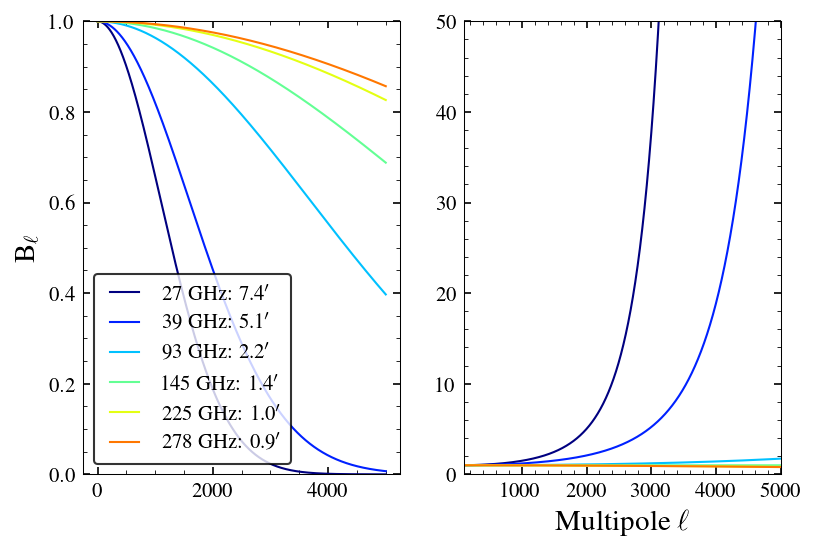

In [31]:
#show beams
for freq in freqarr:
    beam, noise = beam_noise_dic['T'][freq]
    subplot(121)
    plot(bl_dic[freq], color = color_dic[(freq, freq)], label = r'%s GHz: %s$^{\prime}$' %(freq, beam))
    subplot(122)
    plot(bl_dic[145]/bl_dic[freq], color = color_dic[(freq, freq)])
    xlabel(r'Multipole $\ell$', fontsize = 14)
    xlim(xmin, xmax); 
subplot(121)
ylabel(r'B$_{\ell}$', fontsize = 14)
ylim(0., 1.)
legend(loc = 3, ncol = 1, fontsize = 10)
subplot(122)
ylim(0., 50.)
show()